In [1]:
import numpy as np
import sys
import copy
sys.path.append('/home/hcleroy/PostDoc/Simulation/Aging_Condensates/Gillespie_backend/')
from Gillespie_backend import *
import matplotlib.pyplot as plt
import tqdm
from multiprocessing import Pool
from cluster import *
%matplotlib inline
plt.rcParams["figure.figsize"] = (4,3)

# test the clustering module :

In [2]:
position = np.array([0,10,20,30,40])
A = compute_adjacency_matrix(position)
print(compute_clustering(A))
print(A)

position = np.array([0,1,2,3,4])
A = compute_adjacency_matrix(position)
print(compute_clustering(A))
print(A)

-0.015196006460138014
[[0.         0.1        0.05       0.03333333 0.025     ]
 [0.1        0.         0.1        0.05       0.03333333]
 [0.05       0.1        0.         0.1        0.05      ]
 [0.03333333 0.05       0.1        0.         0.1       ]
 [0.025      0.03333333 0.05       0.1        0.        ]]
0.6877076411960132
[[0.         1.         0.5        0.33333333 0.25      ]
 [1.         0.         1.         0.5        0.33333333]
 [0.5        1.         0.         1.         0.5       ]
 [0.33333333 0.5        1.         0.         1.        ]
 [0.25       0.33333333 0.5        1.         0.        ]]


# Equilibration
We first check that the gillespie equilibrates well to a finite number of strand in the gillespie.

In [8]:
def N_strand_time_evolution(step_tot = 100000,
                        ell_tot = 100.,
                        rho0 = 1/100,
                        BindingEnergy = -10.,
                        k_diff = np.exp(-10),
                        seed=1896,
                        sliding=False):
    """
    This function compute the time evolution of the number of bound strand
    in the gillespie.
    """
    S = Gillespie(ell_tot,rho0,BindingEnergy,kdiff=k_diff,seed=seed,sliding=sliding)
    
    Nstrands = np.zeros(step_tot,dtype=int)
    time = np.zeros(step_tot,dtype=float)
    F = np.zeros(step_tot,dtype=float)
    step_check = step_tot//100
    for step in range(step_tot):
        if step%step_check==0:#don't do the actual check all the time, it's quite costly
            if (set(tuple(s) for s in S.get_r_from_loops()) | set(tuple(s) for s in S.get_R())).__len__() < S.get_r().shape[0]+1:
                S.reset_crosslinkers()
        bind,dt = S.evolve(steps=1)
        Nstrands[step] = S.get_N_loop()
        if step>0:
            time[step] = time[step-1]+dt
        else:
            time[0]=dt
        F[step] = S.get_F()
    return time*k_diff,Nstrands,F

In [9]:
Nreplica = 10

pool = Pool(10)

time_strand = np.array(pool.starmap(N_strand_time_evolution,zip(np.array([10**6 for _ in range(Nreplica)]),
                                                       np.array([1000 for _ in range(Nreplica)]),
                                                       np.array([0.00001 for _ in range(Nreplica)]),
                                                       np.array([-10 for _ in range(Nreplica)]),
                                                       np.array([np.exp(-10) for _ in range(Nreplica)]),
                                                       np.array([np.random.randint(0,100000) for _ in range(Nreplica)]),
                                                       np.array([False for _ in range(Nreplica)]))))

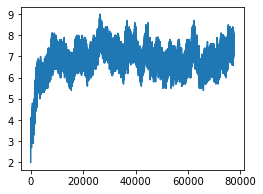

In [10]:
plt.plot(np.mean(time_strand,axis=0)[0],np.mean(time_strand,axis=0)[1])

# evolution of the posistion of the linkers 
20 strands for a length 500 means an average 25 length per strand. We now look at the distribution of strand length.

In [2]:
def get_length_distrib(ell):
    ell_distrib = [ell[0]]
    for l1,l2 in zip(ell,ell[1:]):
        ell_distrib.append(l2-l1)
    return np.array([ell_distrib])

In [27]:
# parameters :
ttot = 10**8
Nmeasure = 100
length = 1000
rho = 10**-5
Eb = -20
k_diff = np.exp(Eb)
S = Gillespie(length,rho,Eb,kdiff=k_diff,seed=np.random.randint(100000),sliding=True)
print('linkers in the vicinity : '+str(S.get_r().shape[0]))
ell_distrib = list()
R_distrib = list()
F = list()
time = list()
for step in range(Nmeasure):
    if (set(tuple(s) for s in S.get_r_from_loops()) | set(tuple(s) for s in S.get_R())).__len__() < S.get_r().shape[0]+1:
        print(step)
        S.reset_crosslinkers()
    move,dts = S.evolve(steps = ttot//Nmeasure)
    if time.__len__() == 0:
        time.append(sum(dts))
        moves = np.array(move)
    else:
        time.append(time[-1]+sum(dts))
        moves = np.append(moves,move)
    ell_distrib.append(S.get_ell_coordinates())
    R_distrib.append(S.get_R())
    F.append(S.get_F())
    
F = np.array(F)
ell_distrib = ell_distrib
R_distrib = R_distrib
time = np.array(time)*k_diff

linkers in the vicinity : 15
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [30]:
clustering_ell = np.array([compute_clustering(compute_adjacency_matrix(ell)) for ell in ell_distrib])
clustering_R = np.array([compute_clustering(compute_adjacency_matrix(R)) for R in R_distrib ])
Nloops=np.zeros(ell_distrib.__len__(),dtype=int)
for n,ells in enumerate(ell_distrib):
    Nloops[n] = ells.__len__()

Text(0.5, 1.0, 'Nloops')

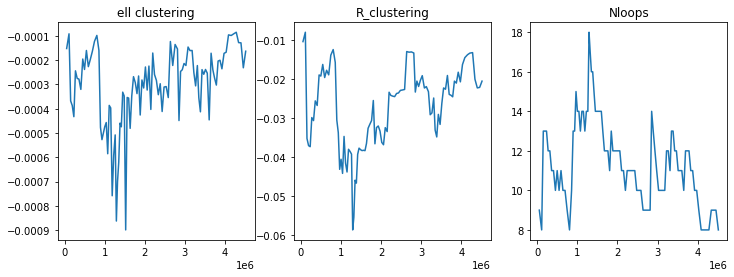

In [31]:
fig, ax = plt.subplots(ncols=3,figsize=(12,4))

ax[0].plot(time,clustering_ell)
ax[0].set_title('ell clustering')

ax[1].plot(time,clustering_R)
ax[1].set_title('R_clustering')

ax[2].plot(time,Nloops)
ax[2].set_title('Nloops')

(<Figure size 288x216 with 1 Axes>, <Axes3DSubplot:xlabel='x', ylabel='y'>)

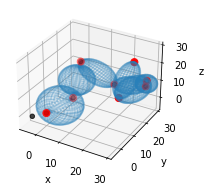

In [32]:
S.Plot3DGillespie()

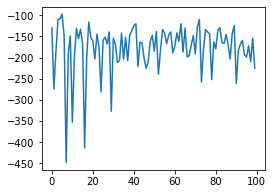

In [17]:
plt.plot(np.arange(0,Nmeasure,1),F)

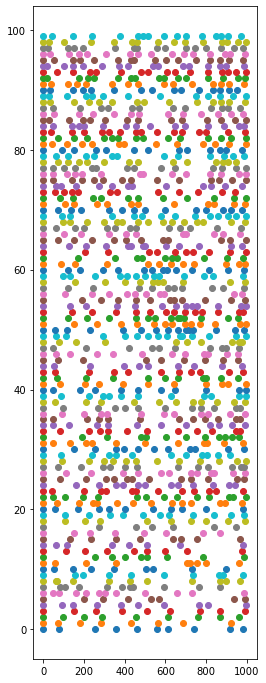

In [19]:
plt.figure(figsize=(4,12))
x = [np.array([i for _ in range(ell_distrib[i].shape[0])]) for i in range(Nmeasure)]
for i in range(Nmeasure):
    plt.scatter(ell_distrib[i],x[i])

In [34]:
def get_length_distrib(ell):
    ell_distrib = [ell[0]]
    for l1,l2 in zip(ell,ell[1:]):
        ell_distrib.append(l2-l1)
    return np.array([ell_distrib])
def distance_distrib(step_tot = 10**5,
                        step_mes = 10**4,
                        ell_tot = 100.,
                        rho0 = 10**-5,
                        BindingEnergy = -10.,
                        k_diff = np.exp(-10),
                        seed=1896,
                        sliding=False):
    """
    This function compute the time evolution of the distance distribution between linkers. To do so, we provide the
    total number of step, and the number of steps between measurement.
    """
    S = Gillespie(ell_tot,rho0,BindingEnergy,kdiff=k_diff,seed=seed,sliding=sliding)
    
    time = np.zeros(step_tot,dtype=float)
    length_distrib=list()
    step_check = step_tot//100
    for step in range(step_tot):
        if step%step_check==0:#don't do the actual check all the time, it's quite costly
            if (set(tuple(s) for s in S.get_r_from_loops()) | set(tuple(s) for s in S.get_R())).__len__() < S.get_r().shape[0]+1:
                S.reset_crosslinkers()
        bind,dt = S.evolve(steps=1)
        if step%step_mes==0:
            length_distrib.append(get_length_distrib(S.get_ell_coordinates())[0])
        if step>0:
            time[step] = time[step-1]+dt
        else:
            time[0]=dt
    return np.array([time[n*step_mes]*k_diff for n in range(step_tot//step_mes)]),length_distrib
def make_pool(step_tot = 10**5,
              step_mes = 10**4,
              ell_tot = 100.,
              rho0 = 10**-5,
              BindingEnergy = -10.,
              k_diff = np.exp(-10),
              seed=1896,
              sliding=False):
    Nreplica = 10
    p = Pool(Nreplica)
    time_length = p.starmap(distance_distrib,zip(np.array([step_tot for _ in range(Nreplica)]),
                                                np.array([step_mes for _ in range(Nreplica)]),
                                                np.array([ell_tot for _ in range(Nreplica)]),
                                                np.array([rho0 for _ in range(Nreplica)]),
                                                np.array([BindingEnergy for _ in range(Nreplica)]),
                                                np.array([k_diff for _ in range(Nreplica)]),
                                                np.array([np.random.randint(100000) for _ in range(Nreplica)]),
                                                np.array([sliding for _ in range(Nreplica)])))
    time = np.zeros(step_tot,dtype=float)
    length = np.array([list() for _ in range(step_tot)])
    for i in range(Nreplica):
        #print(time_length[i])
        time += time_length[i][0]/Nreplica
        for llist in range(step_mes):
            np.append(time_length[i][1][llist],length[llist])
            #print(time_length[i][1][llist][0])
    return time,length

In [35]:
time,length = distance_distrib()

In [36]:
time

array([3.77376839e+00, 9.98991606e+03, 1.84211687e+04, 2.83182803e+04,
       3.84077990e+04, 4.84047114e+04, 5.77558350e+04, 6.76740522e+04,
       7.74930443e+04, 8.73090043e+04])